# Regression Models
- Polyfit (numpy)
- LinearRegression from sklearn
- Moving Average Predictions
- Exponential Smoothing Predictions
- ARIMA/SARIMA Predictions (statsmodels)

In [1]:
# importing the required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.chdir( os.path.join("..", "..", "..") )

# importing custom modules
from Code.src.modules.db_ops import *
from Code.src.modules.dataManager import DataManager
from Code.src.modules.eda import *
from Code.src.modules.db_ops import *

# initializing the DataManager
DM = DataManager()

In [2]:
# importing the data for analysis
df_EnrollmentFinalStatus = DM.get_data('EnrollmentFinalStatus', 'pkl', 'processed')
db_EnrollmentFinalStatus = DM.get_data('EnrollmentFinalStatus', 'db', 'processed')

## Data-Prep
- Getting all the registration semesters
- Getting all the courses
- Merging the two dataframes to fill in the missing semesters


In [3]:
# getting all the registration semesters
reg_term_df = db_EnrollmentFinalStatus.runQuery("""--sql
    SELECT reg_term_desc, reg_term_code
    FROM EnrollmentFinalStatus
    WHERE reg_term_year > 2017
    GROUP BY reg_term_desc, reg_term_code
    ORDER BY reg_term_code
""")
reg_term_df

,reg_term_desc,reg_term_code
0,Spring 2018,201810
1,Fall 2018,201870
2,Spring 2019,201910
3,Fall 2019,201970
4,Spring 2020 - COVID-19,202010
5,Fall 2020,202070
6,Spring 2021,202110
7,Fall 2021,202170
8,Spring 2022,202210
9,Fall 2022,202270


In [4]:
# getting the list of courses
course_list = df_EnrollmentFinalStatus.crs.unique().tolist()
# using 'index' as placeholder for the course index, to be replaced by the looping variable
index = 98

course = course_list[index]
course

'AIT 580'

In [5]:
# Getting the Enrollment data for the `course`
df_crs = db_EnrollmentFinalStatus.runQuery(f"""--sql
    SELECT reg_term_desc, reg_term_code, crs, COUNT(DISTINCT stu_id) as crs_demand
    FROM EnrollmentFinalStatus
    WHERE
        crs = '{course}'
        AND reg_term_year > 2017
    GROUP BY reg_term_desc, reg_term_code
    ORDER BY reg_term_code
;""")
df_crs

,reg_term_desc,reg_term_code,crs,crs_demand
0,Spring 2018,201810,AIT 580,118
1,Fall 2018,201870,AIT 580,137
2,Spring 2019,201910,AIT 580,114
3,Fall 2019,201970,AIT 580,159
4,Spring 2020 - COVID-19,202010,AIT 580,114
5,Fall 2020,202070,AIT 580,128
6,Spring 2021,202110,AIT 580,137
7,Fall 2021,202170,AIT 580,210
8,Spring 2022,202210,AIT 580,212
9,Fall 2022,202270,AIT 580,262


In [6]:
# Merging reg_term_df with df, and filling missing values in crs with course, and crs_demand with 0
# Left Join to keep all the rows from reg_term_df
#   Filtering the columns to keep only the required columns
#       Filling the missing values in crs with course, and crs_demand with 0
#           Renaming the column reg_term_desc_x to reg_term_desc
#               Sorting the values by reg_term_code
#                   Changing the data type of all the columns


df_merge = pd.merge(reg_term_df, df_crs, how='left', on=['reg_term_code']) \
    .filter(['reg_term_desc_x', 'reg_term_code', 'crs', 'crs_demand']) \
        .fillna({'crs': course, 'crs_demand': 0}) \
            .rename(columns={'reg_term_desc_x': 'reg_term_desc'}) \
                .sort_values(by='reg_term_code') \
                    .astype({'reg_term_code': 'int', 'crs_demand': 'int'})
df_merge

,reg_term_desc,reg_term_code,crs,crs_demand
0,Spring 2018,201810,AIT 580,118
1,Fall 2018,201870,AIT 580,137
2,Spring 2019,201910,AIT 580,114
3,Fall 2019,201970,AIT 580,159
4,Spring 2020 - COVID-19,202010,AIT 580,114
5,Fall 2020,202070,AIT 580,128
6,Spring 2021,202110,AIT 580,137
7,Fall 2021,202170,AIT 580,210
8,Spring 2022,202210,AIT 580,212
9,Fall 2022,202270,AIT 580,262


In [7]:
# Filtering df where reg_term_desc like 'Fall'
df = df_merge[df_merge.reg_term_desc.str.contains('Fall')]

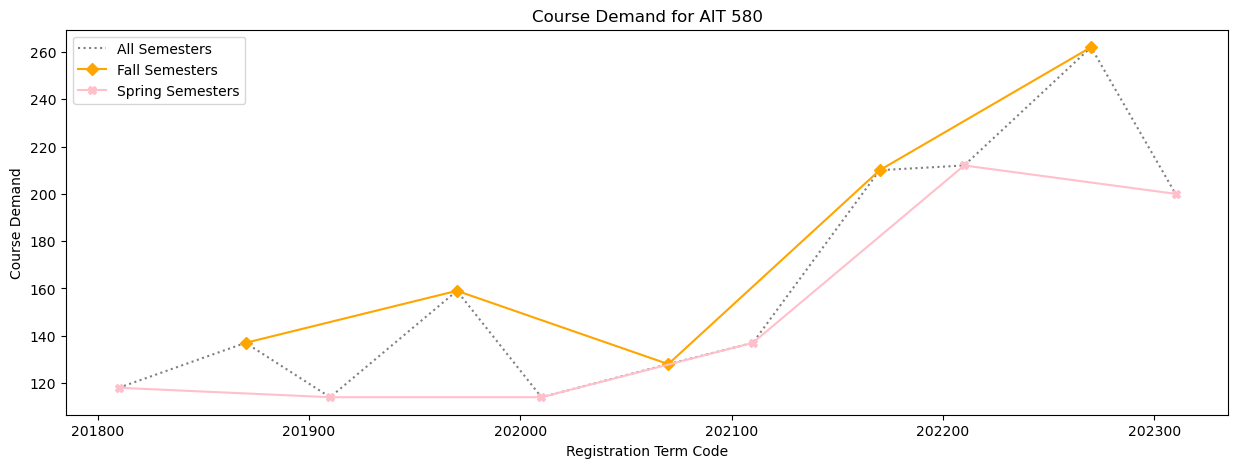

In [8]:
# Plotting the data
plt.figure(figsize=(15, 5))

df = df_merge
plt.plot(df.reg_term_code, df.crs_demand, color='grey', label='All Semesters', linestyle=':')
df = df_merge[df_merge.reg_term_desc.str.contains('Fall')]
plt.plot(df.reg_term_code, df.crs_demand, color='orange', label='Fall Semesters', marker='D')
df = df_merge[df_merge.reg_term_desc.str.contains('Spring')]
plt.plot(df.reg_term_code, df.crs_demand, color='pink', label='Spring Semesters', marker='X')

plt.title(f"Course Demand for {course}")
plt.xlabel("Registration Term Code")
plt.ylabel("Course Demand")
plt.legend()

plt.show()

---
## Polyfit Models

In [11]:
# Hyperparameters
degrees = [1, 2, 3]
semesters = ['Fall', 'Spring']

In [ ]:
# Fitting multiple regression models
for degree in degrees:
    for semester in semesters:

        # Filtering dataframe based on semester
        df = df_merge[df_merge.reg_term_desc.str.contains(semester)]
        df['index'] = df.index
        # Fitting the model
        model = np.polyfit(x=df.index, y=df.crs_demand, deg=degree)

In [20]:
df = df_merge[df_merge.reg_term_desc.str.contains('Fall')]
df['index'] = df.index
# Fitting the model
model = np.polyfit(x=df.reg_term_code, y=df.crs_demand, deg=1, full=True)
model

C:\Users\Sagar-School\AppData\Local\Temp\ipykernel_29572\2449975007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index'] = df.index


(array([ 3.010000e-01, -6.064387e+04]),
 array([3554.7]),
 2,
 array([1.41421348e+00, 4.94877922e-04]),
 1.1102230246251565e-15)

In [15]:
df = df_merge[df_merge.reg_term_desc.str.contains('Fall')]
df['index'] = df.index
# Fitting the model
model = np.polyfit(x=df.index, y=df.crs_demand, deg=3, full=True)
model

C:\Users\Sagar-School\AppData\Local\Temp\ipykernel_29572\2674077540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index'] = df.index


(array([  0.23958333,  -0.50446429,  -1.13244048, 142.81160714]),
 array([1364.01428571]),
 4,
 array([1.8963568 , 0.6178272 , 0.14785545, 0.01609948]),
 1.1102230246251565e-15)